In [1]:
from __future__ import print_function, division

import sys
import os
import glob

import librosa, librosa.display

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf 
import graphviz

import scipy
from scipy.io import wavfile
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
sys.path.append('../scripts')
%matplotlib inline

In [2]:
codebook = pd.read_excel('../data/CMRdataset.xlsx')
codebook = codebook[['fullID', 'Name', 'Artist', 'Lead Instrument Code', 'Taala', 'Raaga','Number of annotated beats','Number of samas']]

# print(codebook.head())

In [4]:
files = []
files.extend(glob.glob(os.path.join("../data/audio", "*.wav")))
# print([file for file in files][0:1])

# Feature Extraction

In [5]:
signals = [
    librosa.load(file, duration=30.0) for file in files[0:2]
]

def featurize(signal):
    signal = np.asarray(signal)[0]
    
    # increase margin for greater harmonic/percussive separation
    stft = librosa.stft(signal)
    H, P = librosa.decompose.hpss(stft, margin=(1.0,5.0))

    return [
        stft,
        H, 
        P,
        librosa.feature.zero_crossing_rate(signal),
        librosa.feature.spectral_centroid(signal)
    ]

features = np.array([featurize(x) for x in signals])
print(features.shape)

# scaler = MinMaxScaler(feature_range=(-1, 1))
# features = scaler.fit_transform(features)
#features[0][0], features[0][1]

(2, 5)


# Modeling 

In [74]:
from tensorflow.keras.layers import Activation, Dense, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, RNN, SimpleRNNCell, GRUCell, LSTMCell
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical, plot_model

In [51]:
# features[i] indexes into the i-th song
# features[i][j] indexes into the j-th feature of the i-th sign 
temp = features[0][0]

In [ ]:
# turn "features" into spectrograms_conv
# Classifying Taala
X = codebook['fullID'].dropna()
Y = codebook['Taala'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [ ]:
len(spectrograms) * .7 #80

def load_data(spec_data):
    
    x_train = np.array([x[1] for x in spec_data[:80]])
    y_train = np.array([x[2] for x in spec_data[:80]])
    
    x_test = np.array([x[1] for x in spec_data[80:]])
    y_test = np.array([x[2] for x in spec_data[80:]])
    
    #print(x_train.shape)
    
    return (x_train, y_train), (x_test, y_test)

shuffle(spectrograms_conv) #shuffle spectrogram data

In [30]:
batch_size = 1
num_classes = 4
epochs = 10

# input image dimensions
img_x, img_y = spectrograms_conv[0][1].shape

# load the spectrogram data
(x_train, y_train), (x_test, y_test) = load_data(spectrograms_conv)

n_train = x_train.shape[0]
n_test = x_test.shape[0]

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x_train.reshape(x_train.shape[0]*img_x, img_y))
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# RGB colour images would have 3, spectrogram data has 1
x_train = scaler.transform(x_train.reshape(x_train.shape[0]*img_x, img_y)).reshape((x_train.shape[0],img_x, img_y,1))

scaler.fit(x_test.reshape(x_test.shape[0]*img_x, img_y))
x_test = scaler.transform(x_test.reshape(x_test.shape[0]*img_x, img_y)).reshape((x_test.shape[0],img_x, img_y,1))


input_shape = (img_x, img_y, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('x_test shape:', x_train.shape)
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below

le = LabelEncoder()
le.fit(y_train)
y_train = tensorflow.keras.utils.to_categorical(le.transform(y_train), num_classes)
y_test = tensorflow.keras.utils.to_categorical(le.transform(y_test), num_classes)

#del spectrograms

NameError: name 'spectrograms_conv' is not defined

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(24, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])

class AccuracyHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, 11), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
del model

In [72]:
# TEST 

# Predicting lead instrument 
input_dim = 100
model = Sequential()
model.add(Dense(size, input_dim=input_dim, activation ='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Generate dummy data
data = np.random.random((1000, 100))
labels = np.random.randint(5, size=(1000, 1))

# Convert labels to categorical one-hot encoding
one_hot_labels = to_categorical(labels, num_classes=5)

ValueError: ('`cell` should have a `call` method. The RNN was passed:', 5)

In [69]:
# Train the model, iterating on the data in batches of 32 samples
history = model.fit(data, one_hot_labels, validation_split=0.25, epochs=15, batch_size=size, verbose=1)

Train on 750 samples, validate on 250 samples
Epoch 1/15
750/750 [==============================] - 1s 773us/step - loss: 1.6049 - acc: 0.1947 - val_loss: 1.6180 - val_acc: 0.2320
Epoch 2/15
750/750 [==============================] - 1s 811us/step - loss: 1.6049 - acc: 0.2027 - val_loss: 1.6190 - val_acc: 0.1720
Epoch 3/15
750/750 [==============================] - 1s 843us/step - loss: 1.6048 - acc: 0.2107 - val_loss: 1.6199 - val_acc: 0.1760
Epoch 4/15
750/750 [==============================] - 1s 821us/step - loss: 1.6048 - acc: 0.1947 - val_loss: 1.6205 - val_acc: 0.1720
Epoch 5/15
750/750 [==============================] - 1s 755us/step - loss: 1.6048 - acc: 0.2187 - val_loss: 1.6207 - val_acc: 0.1760
Epoch 6/15
750/750 [==============================] - 1s 806us/step - loss: 1.6047 - acc: 0.2160 - val_loss: 1.6213 - val_acc: 0.1760
Epoch 7/15
750/750 [==============================] - 1s 771us/step - loss: 1.6048 - acc: 0.2040 - val_loss: 1.6214 - val_acc: 0.1760
Epoch 8/15
750/7

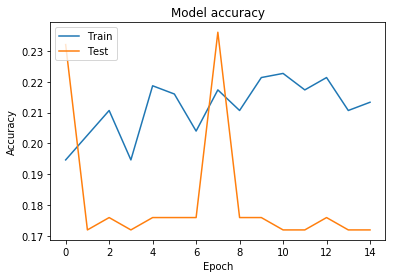

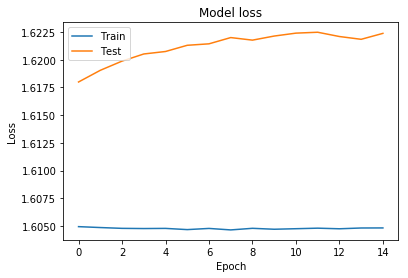

In [70]:
plot_model(model, to_file='../figures/model.png', show_shapes=True)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [71]:
### Feature Extraction 

# Decompose into components based on stft

### Window

# From time domain to frequency domain to make spectrogram 
# Feed spectrograms into RNN or a conv net (2D convolutional network and treat spectrogram as an image) over this transformed domain
# Window size is hyperparameter (window size constant throughout)
# apply basis to the window 

# shared learning
# MEL FCC Change in frequency bins 

### Decomposiion 
# Use to reconstruct new samples 
# Try with different numbers of components 



# Classifying Lead Instrument 
# De-noising with an autoencoder 